In [6]:
from resources.helper.helper_dataset import get_dataloaders_cifar10
from resources.helper.helper_evaluation import set_all_seeds, set_deterministic
from resources.helper.helper_train import train_model
from resources.helper.helper_plotting import plot_training_loss, plot_accuracy, show_examples

import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [8]:
resize_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((70, 70)),
        torchvision.transforms.RandomCrop((64, 64)), 
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
test_resize_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((70, 70)),
        torchvision.transforms.CenterCrop((64, 64)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

train_loader, valid_loader, test_loader = get_dataloaders_cifar10(batch_size=256,validation_fraction=0.1, 
                                                                train_transforms=resize_transform,test_transforms=resize_transform)

In [9]:
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Image batch dimensions: torch.Size([256, 3, 64, 64])
Image label dimensions: torch.Size([256])
Class labels of 10 examples: tensor([7, 8, 8, 6, 0, 7, 0, 3, 4, 3])


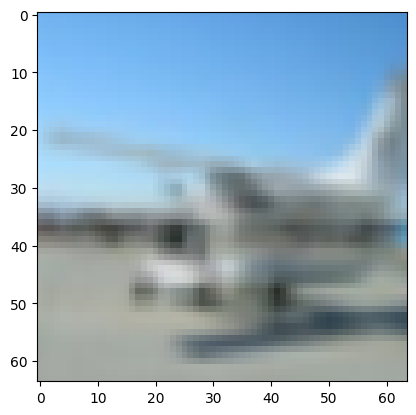

In [10]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
img = images[1]
img = img / 2 + 0.5
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))

plt.show()


In [11]:
class Alexnet(torch.nn.Module):
    def __init__(self,classes, grayscale=False):
        super().__init__()
        self.classes=classes
        if grayscale==False:
            channels=3
        else:
            channels=1
        
        self.features=torch.nn.Sequential(
            torch.nn.Conv2d(channels, 64, kernel_size=11,stride=3, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3,stride=2),

            torch.nn.Conv2d(64, 192, kernel_size=5, padding=2),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3,stride=2),

            torch.nn.Conv2d(192, 384, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),

            torch.nn.Conv2d(384,256, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),

            torch.nn.Conv2d(256,256, kernel_size=3, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3,stride=2),
            )
        self.avgpooling=torch.nn.AdaptiveAvgPool2d((6,6))
        
        self.classifier=torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256*6*6,4096),
            torch.nn.ReLU(inplace=True),
            
            torch.nn.Dropout(0.5),
            torch.nn.Linear(4096,4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(4096,classes),

        )

    def forward(self, x):
        x=self.features(x)
        x=self.avgpooling(x)
        x=x.view(x.size(0),256*6*6)
        logits=self.classifier(x)
        return logits

In [12]:
model=Alexnet(10)
model=model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.1, mode='max')
Epochs=5
minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=Epochs,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=device,
    logging_interval=50,
    scheduler=scheduler,
    scheduler_on='valid_acc')

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=Epochs,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=20)

plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)

plt.ylim([80, 100])
plt.show()

Epoch: 001/005 | Batch 0000/0175 | Loss: 2.3026


KeyboardInterrupt: 